In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import math 

df = pd.read_csv('main_task.csv')

# EDA
### Первичный осмотр данных 

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvosor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [2]:
df[:10]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


#### В данных у нас есть:
- 10 столбцов 
- 40000 строк
- так же есть пропуски 
- в основном у нас тип данных object

## Посчитаем количество пустых строк для каждого столбца в дасасете


In [4]:
NaN_Sum = lambda col: col.isnull().sum()  # Функция для определения количества нулевых знчений  
columns = list(df.columns)
for col in columns:
    print("Количество пустых значений", col, NaN_Sum(df[col]), sep=' ')

Количество пустых значений Restaurant_id 0
Количество пустых значений City 0
Количество пустых значений Cuisine Style 9283
Количество пустых значений Ranking 0
Количество пустых значений Rating 0
Количество пустых значений Price Range 13886
Количество пустых значений Number of Reviews 2543
Количество пустых значений Reviews 0
Количество пустых значений URL_TA 0
Количество пустых значений ID_TA 0


### Проверим численные столбцы на выбросы 
- Ranking 
- Rating 
- Number of Reviews

In [5]:
num_columns=['Ranking','Rating','Number of Reviews']

In [6]:
def Qantil(data, n):
    median = data[num_columns[n]].median()
    IQR = data[num_columns[n]].quantile(0.75) - data[num_columns[n]].quantile(0.25)
    perc25 = data[num_columns[n]].quantile(0.25)
    perc75 = data[num_columns[n]].quantile(0.75)
    print(num_columns[n], '25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
          , "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5 * IQR, l=perc75 + 1.5 * IQR))
    data = data.loc[data[num_columns[0]].between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)]
    data[num_columns[n]].hist()
    data[num_columns[n]].describe()

#  Ranking

Ranking 25-й перцентиль: 973.0, 75-й перцентиль: 5260.0, IQR: 4287.0,  Границы выбросов: [-5457.5, 11690.5].


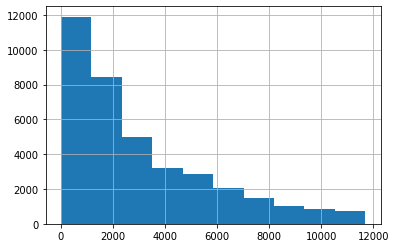

In [7]:
Qantil(df,0)

# Rating

Rating 25-й перцентиль: 3.5, 75-й перцентиль: 4.5, IQR: 1.0,  Границы выбросов: [2.0, 6.0].


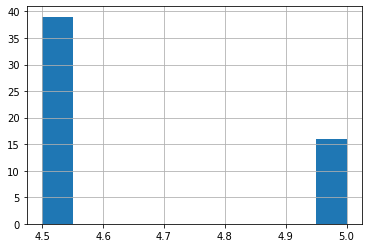

In [8]:
Qantil(df,1)

# Number of Reviews

Number of Reviews 25-й перцентиль: 9.0, 75-й перцентиль: 115.0, IQR: 106.0,  Границы выбросов: [-150.0, 274.0].


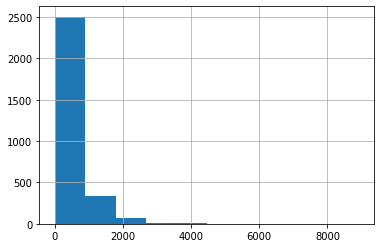

In [9]:
Qantil(df,2)

# Корреляционный анализ 

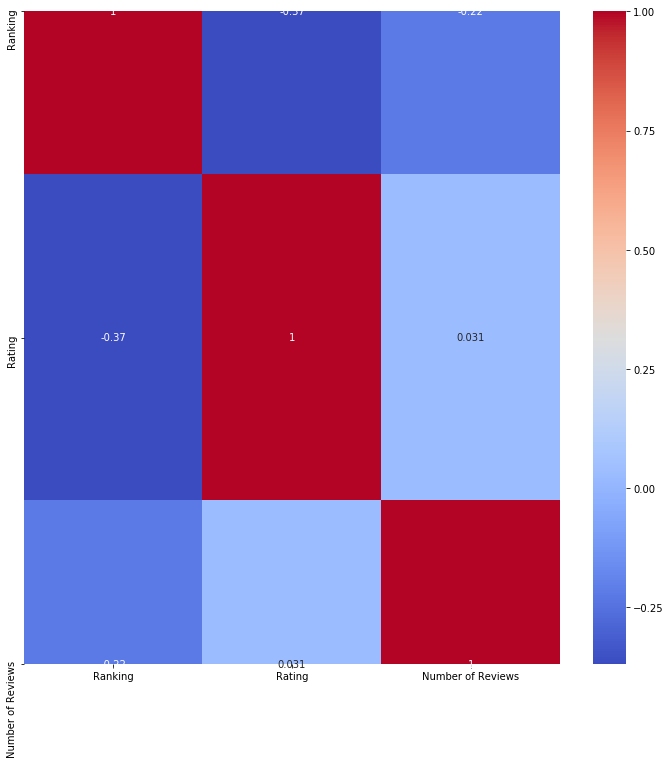

In [10]:
correlation = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation,annot=True,cmap='coolwarm')

In [11]:
# Этот анализ не даёт объективных данных поэтому сделаем его позже 

# Очистка данных и создание новых признаков 

In [12]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(int(df['Number of Reviews'].mean()))

In [13]:
# Создаем уникальные значения для столбца Price Range
def Prise_Range_Uniq(data):
    for i in range(len(data)):
        if data[i] == '$':
            data[i] = 1
        elif data[i] == '$$ - $$$':
            data[i] = 2
        elif data[i] == '$$$$':
            data[i] = 3
    return data


In [14]:
Prise_Range_Uniq(df['Price Range'])

0          2
1        NaN
2          3
3        NaN
4          2
        ... 
39995      2
39996      2
39997    NaN
39998      2
39999      2
Name: Price Range, Length: 40000, dtype: object

In [15]:
df['Price Range'] = df['Price Range'].fillna(int(df['Price Range'].mean()))
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,1,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,1,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [16]:
def IDTA_Uniq(data):
    return int(data[1:])


df['ID_TA'] = df['ID_TA'].apply(IDTA_Uniq)

In [17]:
# Функция создающая количество кухонь у ресторана
def CountStyle(data):
        count = []
        for i in range(len(data)):
            if type(data[i]) == str:
                count.append(int(len(data[i].split(','))))
        return count
    
    
df['Cuisine Count'] = pd.Series(CountStyle(df['Cuisine Style'])) 
df['Cuisine Count'] = df['Cuisine Count'].fillna(int(df['Cuisine Count'].mean()))

In [18]:
# Фукнция создающая уникальные номера для городов 
# Не использовалась в конечной модели 
def City_Uniq(data):
    City={'Paris':1,'Stockholm':2,'London':3,'Berlin':4,'Munich':5,'Oporto':6,
          'Milan':7,'Bratislava':8,'Vienna':9,'Rome':10,'Barcelona':11,'Madrid':12,
         'Dublin':13,'Brussels':14,'Zurich':15,'Warsaw':16,'Budapest':17,'Copenhagen':18,
         'Amsterdam':19,'Lyon':20,'Hamburg':21,'Lisbon':22,'Prague':23,'Oslo':24,
         'Helsinki':25,'Edinburgh':26,'Geneva':27,'Ljubljana':28,'Athens':29,
          'Luxembourg':30,'Krakow':31
         }
    return City.get(data)


# df['City'] = df['City'].apply(City_Uniq)

In [19]:
# Количество записей отзывов
def Reviews(data):
    return len(data.split(','))


df['Rev'] = pd.Series(df['Reviews'].apply(Reviews))
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Cuisine Count,Rev
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,3.0,4
1,id_1535,Stockholm,NaN,1537.0,4.0,1,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,7.0,4
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,3.0,4
3,id_3456,Berlin,NaN,3458.0,5.0,1,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,1358776,2.0,2
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,6864963,1.0,4


In [20]:
# Убираем столбцы object
df = df.drop(['URL_TA'],axis=1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          40000 non-null int64
Number of Reviews    40000 non-null float64
Reviews              40000 non-null object
ID_TA                40000 non-null int64
Cuisine Count        40000 non-null float64
Rev                  40000 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 3.4+ MB


# Еще раз корреляционный анализ 

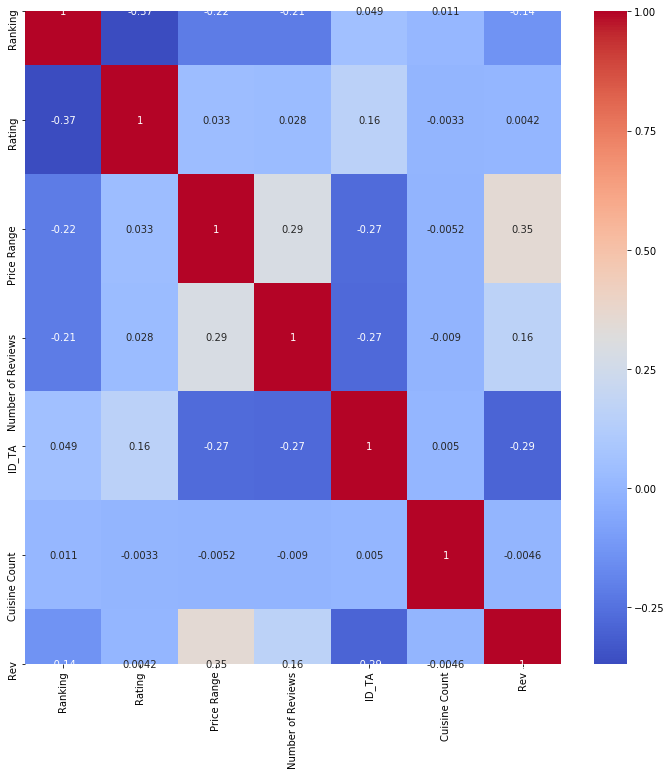

In [22]:
correlation = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation,annot=True,cmap='coolwarm')

#### Тут уже видны некоторые зависимости и можно сделать некоторые выводы 


##### Теперь возьмем все не численные переменные и проведем номинативный анализ 
- City 
- Cuisine Style 

In [23]:
no_num = ['City','Cuisine Style']

### Теперь проведем анализ на выявление взаимосвязи между score и всеми остальными параметрами

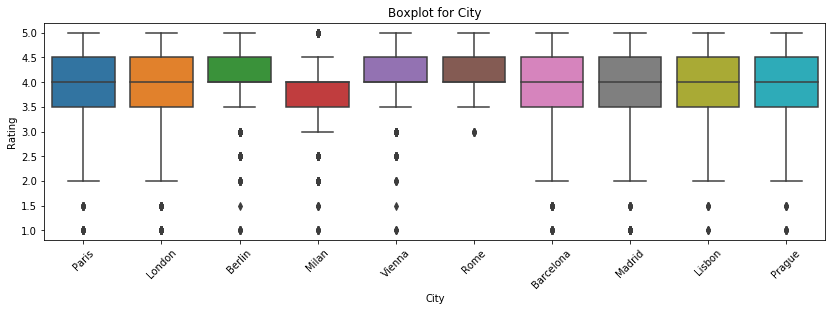

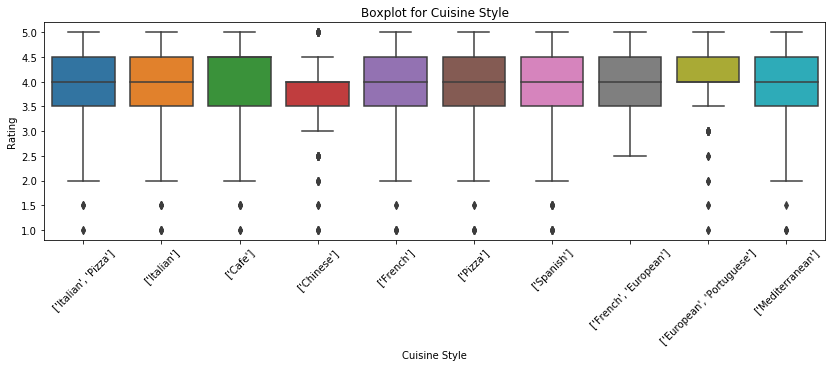

In [27]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='Rating',
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
for coll in no_num:
    get_boxplot(coll)    